In [1]:
MAX_TIME = 30
INIT_SIZE = 10
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'14-torch_bartz09_30min_10init_2023-05-14_14-45-25'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.1.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip list | grep  "torch"

torch                    2.0.1
torchvision              0.15.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
!{sys.executable} --version

Python 3.10.10


In [6]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [7]:
from tabulate import tabulate
import warnings
import json
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    get_bound_values,
    get_default_values,
    get_var_name,
    get_var_type,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
)
from spotPython.torch.traintest import (
    evaluate_cv,
    evaluate_hold_out,
    train_save,
    test_saved,
    )
from spotPython.utils.eda import gen_design_table
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.init import fun_control_init

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netcifar10 import Net_CIFAR10

warnings.filterwarnings("ignore")

In [8]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.1
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [9]:
fun_control = fun_control_init()

## 1. Load Cifar10 Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [10]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [11]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [12]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [13]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [14]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters

In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [15]:
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[1, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[5, 5])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 5},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0},
 'patience': {'type': 'int',
  'default': 5,
  'transform': 'None',
  'lower': 5,
  'upper': 5}}

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [16]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [17]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
save_model = True
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "save_model": save_model,
               "path": path,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.
* This step is necessary, because some parameters from the `fun_control` dictionary are explicitly required by the SPOT function.

In [18]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [19]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    5    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |
| patience   | int    |     5     |   5     |    5    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [20]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00, 5.e+00]])

In [21]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 1.6353180953025819
Accuracy on hold-out set: 0.3911
Epoch: 2
Loss on hold-out set: 1.4820956779479981
Accuracy on hold-out set: 0.46695
Epoch: 3
Loss on hold-out set: 1.3938081372737885
Accuracy on hold-out set: 0.5009
Epoch: 4
Loss on hold-out set: 1.3035346683502198
Accuracy on hold-out set: 0.5398
Epoch: 5
Loss on hold-out set: 1.2625244483947753
Accuracy on hold-out set: 0.5537
Epoch: 6
Loss on hold-out set: 1.2672124380588532
Accuracy on hold-out set: 0.5577
Epoch: 7
Loss on hold-out set: 1.2238256118774413
Accuracy on hold-out set: 0.5713
Epoch: 8
Loss on hold-out set: 1.1821977684020997
Accuracy on hold-out set: 0.5859
Epoch: 9
Loss on hold-out set: 1.1672988702297211
Accuracy on hold-out set: 0.58965
Epoch: 10
Loss on hold-out set: 1.2051970479488372
Accuracy on hold-out set: 0.57935
Epoch: 11
Loss on hold-out set: 1.1606332218170166
Accuracy on hold-out set: 0.5967
Epoch: 12
Loss on hold-out set: 1.1754896848678589
Accuracy on hold-out set: 0.598

### 4 Results

In [22]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [23]:
spot_tuner.y

array([1.19396536, 1.27113197, 1.24557704, 1.2840838 , 1.22348957,
       1.23777906, 1.50096927, 2.12097552, 1.39954704, 1.33148146,
       1.30373735, 1.27001508, 1.19381762, 1.15411837, 1.1665814 ,
       1.15325055, 1.3547857 , 1.1623107 , 1.1217431 ])

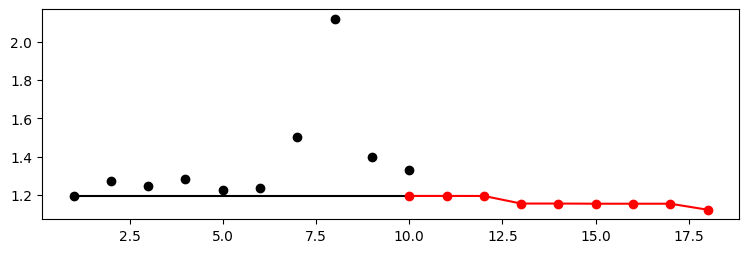

In [24]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")

* Print the Results

In [25]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  6.0 | transform_power_2_int |        74.93 | **      |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  5.0 | transform_power_2_int |         0.00 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.003810130210141329 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     5.0 |                  4.0 | transform_power_2_int |        75.39 | **      |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                  4.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |  

## Show variable importance

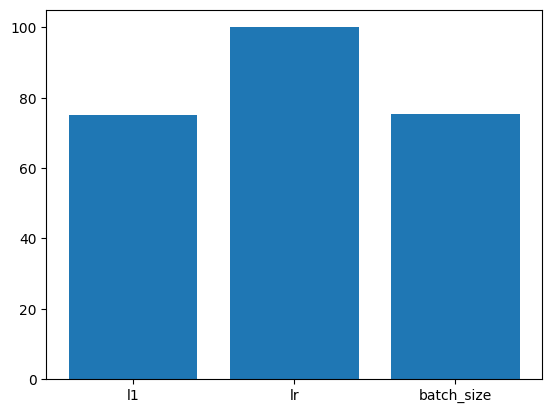

In [26]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [27]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32,
 'l2': 32,
 'lr': 0.001,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 2,
 'patience': 5}

In [28]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [29]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[6.00000000e+00 5.00000000e+00 3.81013021e-03 4.00000000e+00
  4.00000000e+00 0.00000000e+00 5.00000000e+00]]


In [30]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 64,
  'l2': 32,
  'lr': 0.003810130210141329,
  'batch_size': 16,
  'epochs': 16,
  'k_folds': 0,
  'patience': 5}]

In [31]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Evaluations

The method `train_save` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model model_state_dict is saved.

 This evaluation is similar to the final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [32]:
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [45]:
train_save(net=model_default, train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_default_trained.pt", save_model=True)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.399
Loss on hold-out set: 1.3988841579437257
Accuracy on hold-out set: 0.4957
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.393
Loss on hold-out set: 1.3932536019325257
Accuracy on hold-out set: 0.50145
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.363
Loss on hold-out set: 1.3770612518310548
Accuracy on hold-out set: 0.50675
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.360
Loss on hold-out set: 1.357368537378311
Accuracy on hold-out set: 0.51465
Epoch: 5
Batch:  1000. Batch Size: 16. Training Loss (running): 1.336
Loss on hold-out set: 1.3437017423152924
Accuracy on hold-out set: 0.51995
Epoch: 6
Batch:  1000. Batch Size: 16. Training Loss (running): 1.335
Loss on hold-out set: 1.3492213349342346
Accuracy on hold-out set: 0.5155
Epoch: 7
Batch:  1000. Batch Size: 16. Training Loss (running): 1.303
Loss on hold-out set: 1.3277261384487151
Accuracy on hold-out s

(1.3151872980117798, nan)

In [34]:
test_saved(net=model_default, test_dataset=test, shuffle=False, device = "cpu", show_batch_interval=1_000, path="model_default_trained.pt")

Loss on hold-out set: 1.1560633163452148
Accuracy on hold-out set: 0.5934
Returned to Spot: Validation loss: 1.1560633163452148
----------------------------------------------


(1.1560633163452148, nan)

In [35]:
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:

train_save(net=model_spot, train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt", save_model=True)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.069
Loss on hold-out set: 1.104799135541916
Accuracy on hold-out set: 0.6138
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.042
Loss on hold-out set: 1.0727831973075868
Accuracy on hold-out set: 0.6229
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.017
Loss on hold-out set: 1.072711392402649
Accuracy on hold-out set: 0.6251
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 0.989
Loss on hold-out set: 1.0525790733218192
Accuracy on hold-out set: 0.6269
Epoch: 5
Batch:  1000. Batch Size: 16. Training Loss (running): 0.951
Loss on hold-out set: 1.0658962021827698
Accuracy on hold-out set: 0.629
Epoch: 6
Batch:  1000. Batch Size: 16. Training Loss (running): 0.936
Loss on hold-out set: 1.1321928074836731
Accuracy on hold-out set: 0.6074
Epoch: 7
Batch:  1000. Batch Size: 16. Training Loss (running): 0.935
Loss on hold-out set: 1.0893589721441268
Accuracy on hold-out set: 0.

(1.0685887334108353, nan)

In [37]:
test_saved(net=model_spot, test_dataset=test, shuffle=False, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt")

Loss on hold-out set: 1.1034918918132781
Accuracy on hold-out set: 0.6184
Returned to Spot: Validation loss: 1.1034918918132781
----------------------------------------------


(1.1034918918132781, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  74.92973581202024
lr:  100.0
batch_size:  75.38533972506202


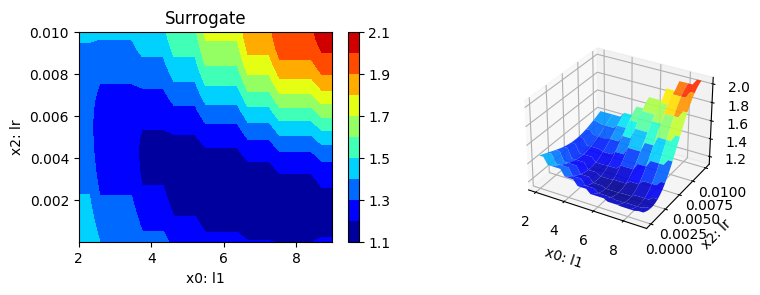

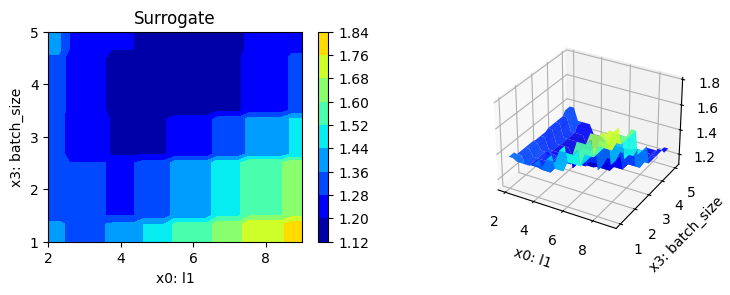

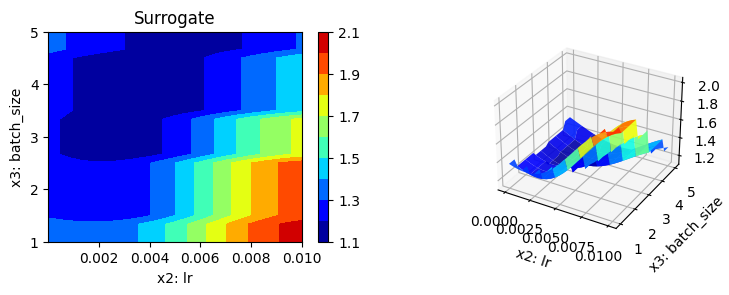

In [38]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [39]:
spot_tuner.parallel_plot()

# Additional Evaluations

Two evaluations are performed: First, the test data is used only: the test data is used for training the model and for evaluating the model. Second, the train and test data are used: the model is trained with the train data and evaluated with the test data.

## Test Set Accuracy

The tuned model architecture (i.e., the model without pre-trained weights) is used for training and testing the model with the test data.
The default model is considered first.

In [40]:
evaluate_hold_out(net=model_default, train_dataset=test, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 2.3025950508117674
Accuracy on hold-out set: 0.1025
Epoch: 2
Loss on hold-out set: 2.297680314064026
Accuracy on hold-out set: 0.15225
Epoch: 3
Loss on hold-out set: 2.2824411163330076
Accuracy on hold-out set: 0.179
Epoch: 4
Loss on hold-out set: 2.1628748540878298
Accuracy on hold-out set: 0.20175
Epoch: 5
Loss on hold-out set: 2.032757287979126
Accuracy on hold-out set: 0.25125
Epoch: 6
Loss on hold-out set: 1.9711315383911132
Accuracy on hold-out set: 0.273
Epoch: 7
Loss on hold-out set: 1.9307509570121766
Accuracy on hold-out set: 0.29
Epoch: 8
Loss on hold-out set: 1.9013607020378114
Accuracy on hold-out set: 0.30625
Returned to Spot: Validation loss: 1.9013607020378114
----------------------------------------------


(1.9013607020378114, nan)

In [41]:
evaluate_hold_out(net=model_spot, train_dataset=test, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 1.107497502565384
Accuracy on hold-out set: 0.6155
Epoch: 2
Loss on hold-out set: 1.1100917348861694
Accuracy on hold-out set: 0.6135
Epoch: 3
Loss on hold-out set: 1.1102623360157013
Accuracy on hold-out set: 0.61225
Epoch: 4
Loss on hold-out set: 1.1181481244564055
Accuracy on hold-out set: 0.61525
Epoch: 5
Loss on hold-out set: 1.1333141725063325
Accuracy on hold-out set: 0.6125
Epoch: 6
Loss on hold-out set: 1.147283921957016
Accuracy on hold-out set: 0.61275
Early stopping at epoch 5
Returned to Spot: Validation loss: 1.147283921957016
----------------------------------------------


(1.147283921957016, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

The final evaluation is performed with the train and test data. The model (without pre-trained weights) is trained with the train data and evaluated with the test data.

In [42]:
evaluate_hold_out(net=model_default, train_dataset=train, shuffle=False, test_dataset=test, show_batch_interval=1_000) 

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.894
Batch:  2000. Batch Size: 16. Training Loss (running): 0.916
Batch:  3000. Batch Size: 16. Training Loss (running): 0.600
Loss on hold-out set: 1.7551928733825684
Accuracy on hold-out set: 0.3616
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.762
Batch:  2000. Batch Size: 16. Training Loss (running): 0.857
Batch:  3000. Batch Size: 16. Training Loss (running): 0.569
Loss on hold-out set: 1.6654648836135864
Accuracy on hold-out set: 0.3891
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.679
Batch:  2000. Batch Size: 16. Training Loss (running): 0.821
Batch:  3000. Batch Size: 16. Training Loss (running): 0.548
Loss on hold-out set: 1.6047151784896851
Accuracy on hold-out set: 0.4094
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.615
Batch:  2000. Batch Size: 16. Training Loss (running): 0.789
Batch:  3000. Batch Size: 16. Training Loss (running): 0.530
Loss on ho

(1.4165556290626526, nan)

In [43]:
evaluate_hold_out(net=model_spot, train_dataset=train, shuffle=False, test_dataset=test, show_batch_interval=1_000)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.000
Batch:  2000. Batch Size: 16. Training Loss (running): 0.488
Batch:  3000. Batch Size: 16. Training Loss (running): 0.332
Loss on hold-out set: 0.9955151764154434
Accuracy on hold-out set: 0.6492
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 0.947
Batch:  2000. Batch Size: 16. Training Loss (running): 0.468
Batch:  3000. Batch Size: 16. Training Loss (running): 0.321
Loss on hold-out set: 1.0077301990509033
Accuracy on hold-out set: 0.6478
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 0.925
Batch:  2000. Batch Size: 16. Training Loss (running): 0.456
Batch:  3000. Batch Size: 16. Training Loss (running): 0.313
Loss on hold-out set: 1.0184763174057008
Accuracy on hold-out set: 0.6458
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 0.908
Batch:  2000. Batch Size: 16. Training Loss (running): 0.448
Batch:  3000. Batch Size: 16. Training Loss (running): 0.307
Loss on ho

(1.042384707903862, nan)

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [44]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)